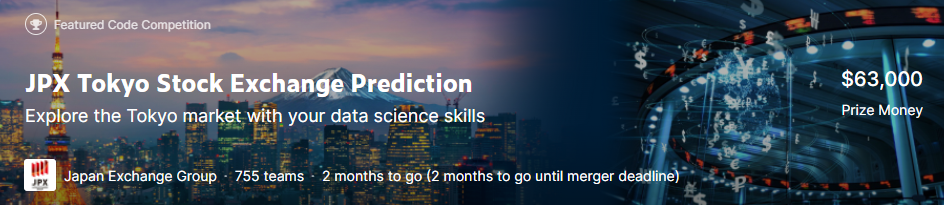

### First Japanese owner's competition. It's another future prediction type competition.
### I will solve it a little every day.
### Once the code is competitive, I will make it PRIVATE as usual.

<span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Import</span>

In [ ]:
import os
import pickle
import sys
import warnings
from glob import glob

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import xgboost
from scipy.stats import spearmanr
from sklearn.ensemble import (
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    RandomForestRegressor,
)
from sklearn.metrics import accuracy_score, mean_squared_error
from tqdm.notebook import tqdm

<span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">data_specifications</span>

In [ ]:
dataset_dir="../input/jpx-tokyo-stock-exchange-prediction/data_specifications/"
# 読み込むファイルを定義します。
inputs = {
    "options_spec": f"{dataset_dir}/options_spec.csv",
    "stock_fin_spec": f"{dataset_dir}/stock_fin_spec.csv",
    "stock_list_spec.csv": f"{dataset_dir}/stock_list_spec.csv",
    "stock_price_spec": f"{dataset_dir}/stock_price_spec.csv",
    "trades_spec": f"{dataset_dir}/trades_spec.csv",
}

# ファイルを読み込みます
data_specifications = {}
for k, v in inputs.items():
    print(k)
    data_specifications[k] = pd.read_csv(v)

<span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">example_test_files</span>

 ### Same data as provided by the API

In [ ]:
dataset_dir="../input/jpx-tokyo-stock-exchange-prediction/example_test_files/"
inputs = {
    "financials": f"{dataset_dir}/financials.csv",
    "options": f"{dataset_dir}/options.csv",
    "secondary_stock_prices": f"{dataset_dir}secondary_stock_prices.csv",
    "stock_prices": f"{dataset_dir}/stock_prices.csv",
    "trades": f"{dataset_dir}/trades.csv",
}

example_test_files = {}
for k, v in inputs.items():
    print(k)
    example_test_files[k] = pd.read_csv(v)

### This will be the submission.
### You will be expected to predict Rank.

In [ ]:
sample_submission = pd.read_csv('../input/jpx-tokyo-stock-exchange-prediction/example_test_files/sample_submission.csv')
sample_submission

<span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">supplemental_files</span>


Data folder containing dynamic window of supplemental training data

In [ ]:
dataset_dir="../input/jpx-tokyo-stock-exchange-prediction/supplemental_files/"
inputs = {
    "financials": f"{dataset_dir}/financials.csv",
    "options": f"{dataset_dir}/options.csv",
    "secondary_stock_prices": f"{dataset_dir}secondary_stock_prices.csv",
    "stock_prices": f"{dataset_dir}/stock_prices.csv",
    "trades": f"{dataset_dir}/trades.csv",
}

supplemental_files = {}
for k, v in inputs.items():
    print(k)
    supplemental_files[k] = pd.read_csv(v)

<span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">train_files</span>


### Results of Quarterly Financial Reporting

In [ ]:
dataset_dir="../input/jpx-tokyo-stock-exchange-prediction/train_files/"
inputs = {
    "financials": f"{dataset_dir}/financials.csv",
    "options": f"{dataset_dir}/options.csv",
    "secondary_stock_prices": f"{dataset_dir}secondary_stock_prices.csv",
    "stock_prices": f"{dataset_dir}/stock_prices.csv",
    "trades": f"{dataset_dir}/trades.csv",
}

train = {}
for k, v in inputs.items():
    print(k)
    train[k] = pd.read_csv(v)


### Let's analyze the code of the 1301 issue to see if it works.

In [ ]:
price = train["stock_prices"]

code = 1301
price_data = price[price["SecuritiesCode"] == code]
price_data

In [ ]:
price = train["stock_prices"]

code = 1301
price_data = price[price["SecuritiesCode"] == code]

# プロット
fig, ax = plt.subplots(figsize=(20, 8))

ax.plot(price_data['Date'],price_data["Open"], label=f"securities code : {code}.T")
ax.plot(price_data['Date'],price_data["High"], label=f"securities code : {code}.T")
ax.plot(price_data['Date'],price_data["Low"], label=f"securities code : {code}.T")
ax.plot(price_data['Date'],price_data["Close"], label=f"securities code : {code}.T")
plt.xticks([0, 200,400,600,800, 1000,1200])
ax.set_ylabel("stock_price")
ax.set_xlabel("datetime")
ax.grid(True)
ax.legend()

### Target

In [ ]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(price_data['Date'],price_data["Target"], label=f"securities code : {code}.T")
plt.xticks([0, 200,400,600,800, 1000,1200])
ax.set_ylabel("stock_price")
ax.set_xlabel("datetime")
ax.grid(True)
ax.legend()


# moving average


Moving averages There are many types of but here we will use a simple moving The average line is used. A simple moving average is For example, a 5-day line is the last 5 business days. The average of the price over the past The following is a summary of the results of the survey. This is the period Sliding down the The calculation is based on The following table shows the results.

In [ ]:

periods = [5, 25, 75]
cols = []
for period in periods:
    col = "{} windows simple moving average".format(period)
    price_data[col] = price_data["Open"].rolling(period, min_periods=1).mean()
    cols.append(col)

# プロット
fig, ax = plt.subplots(figsize=(20, 8))

for col in cols:
    ax.plot(price_data['Date'],price_data[col], label=col)
ax.set_ylabel("stock_price")
ax.set_xlabel("datetime")
plt.xticks([0, 200,400,600,800, 1000,1200])
ax.grid(True)
ax.legend()

### 


# Price change ratio


The rate of price change is the rate at which the price The amount of time between the change in (%). The following table shows the number of shares of the company's common stock. market momentum and direction. The following is a list of the most common It is often used

In [ ]:
periods = [5, 25, 75]
cols = []
for period in periods:
    col = "{} windows rate of return".format(period)
    price_data[col] = price_data["Open"].pct_change(period) * 100
    cols.append(col)


fig, ax = plt.subplots(figsize=(20, 8))

for col in cols:
    ax.plot(price_data['Date'],price_data[col], label=col)
ax.set_ylabel("rate of return (%)")
ax.set_xlabel("datetime")
plt.xticks([0, 200,400,600,800, 1000,1200])
ax.grid(True)
ax.legend()


# Historical volatility


Historical Volatility Calculate the equity. The histo Volatility is the number of days between the 5-day, 25-day, and 75-day Standard deviation of logarithmic returns The following table shows the number of shares of each company. Historical Volatility The risk indicator is a risk measure of It is one of the how severely they have fluctuated. The purpose of this method is to The following is a list of the most common Generally, historical The large volatility of the stocks are more likely to be than the asset Relative risk of holding The number of The following is a summary of the results of the survey.

In [ ]:

periods = [5, 25, 75]
cols = []
for period in periods:
    col = "{} windows volatility".format(period)
    price_data[col] = np.log(price_data["Open"]).diff().rolling(period).std()
    cols.append(col)


fig, ax = plt.subplots(figsize=(20, 8))

for col in cols:
    ax.plot(price_data['Date'],price_data[col], label=col)
ax.set_ylabel("volatility")
ax.set_xlabel("datetime")
plt.xticks([0, 200,400,600,800, 1000,1200])
ax.grid(True)
ax.legend()


## Missing value processing



There are quite a few missing values.

In [ ]:
price_data['year'] = price_data.Date.str[:4]

In [ ]:
print(price_data.isna().sum())


### Plot missing data values

In [ ]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.heatmap(price_data.groupby("year").agg("sum"), ax=ax)


## Generate features


### Stationarity-aware feature design

When dealing with time series data, it is important to design features with stationarity in mind.

Let us consider the case of learning stock prices as they are and the case of using features with stationarity.

Case where stock prices are learned as they are: Suppose, for example, that the stock prices during the training period of the model move in the range of 100-110 yen. If this value is input directly into the model, the model implicitly learns that the stock price moves in the range of 100-110 yen. However, this implicit assumption is not valid in the actual market, and the model may not work well if the stock price soars during the test period. Another example specific to stock prices is when the range of stock prices fluctuates significantly due to stock splits or reverse stock splits.

Cases that use features that are stationary: For example, considering a 20-day price change rate, this is not a normal distribution, but it is close to a normal distribution centered around approximately 0, except during some periods of market turmoil. The characteristics are time series centered around 0, such as a 2% rise or a 4% decline, and can be expected to have a similar distribution in the future, eliminating the fear of learning implicit assumptions about the stock price range. Thus, a feature that can be expected to have a similar distribution in the future can be said to be stationary.

With stationarity in mind, various caveats in the normalization process become apparent. For example, if we apply MinMax normalization, which maps the minimum and maximum values from -1 to 1, to stock prices, we cannot expect stationarity. This is because there is no guarantee that the maximum and minimum values of MinMax normalization for stock prices will be applicable in the future. Thus, when designing time series features, it is important to design features with stationarity in mind.

In [ ]:

feats = price_data.copy()

feats["return_1month"] = feats["Close"].pct_change(20)

feats["return_2month"] = feats["Close"].pct_change(40)

feats["return_3month"] = feats["Close"].pct_change(60)

feats["volatility_1month"] = (
    np.log(feats["Close"]).diff().rolling(20).std()
)

feats["volatility_2month"] = (
    np.log(feats["Close"]).diff().rolling(40).std()
)

feats["volatility_3month"] = (
    np.log(feats["Close"]).diff().rolling(60).std()
)

feats["MA_gap_1month"] = feats["Close"] / (
    feats["Close"].rolling(20).mean()
)

feats["MA_gap_2month"] = feats["Close"] / (
    feats["Close"].rolling(40).mean()
)

feats["MA_gap_3month"] = feats["Close"] / (
    feats["Close"].rolling(60).mean()
)

feats = feats.fillna(0)

feats = feats.drop(["Close"], axis=1)


### 20 business day return of closing price

In [ ]:

fig, ax = plt.subplots(figsize=(20, 8))

ax.plot(feats['Date'],feats["return_1month"])
ax.set_ylabel("volatility")
ax.set_xlabel("datetime")
plt.xticks([0, 200,400,600,800, 1000,1200])
ax.grid(True)
ax.legend()


### 40 business day return of closing price

In [ ]:

fig, ax = plt.subplots(figsize=(20, 8))

ax.plot(feats['Date'],feats["return_2month"])
ax.set_ylabel("volatility")
ax.set_xlabel("datetime")
plt.xticks([0, 200,400,600,800, 1000,1200])
ax.grid(True)
ax.legend()


### 60 business day return of closing price

In [ ]:

fig, ax = plt.subplots(figsize=(20, 8))

ax.plot(feats['Date'],feats["return_3month"])
ax.set_ylabel("volatility")
ax.set_xlabel("datetime")
plt.xticks([0, 200,400,600,800, 1000,1200])
ax.grid(True)
ax.legend()


## 20 business day volatility of closing price

In [ ]:

fig, ax = plt.subplots(figsize=(20, 8))

ax.plot(feats['Date'],feats["volatility_1month"])
ax.set_ylabel("volatility")
ax.set_xlabel("datetime")
plt.xticks([0, 200,400,600,800, 1000,1200])
ax.grid(True)
ax.legend()


## 40 business day volatility of closing price

In [ ]:

fig, ax = plt.subplots(figsize=(20, 8))

ax.plot(feats['Date'],feats["volatility_2month"])
ax.set_ylabel("volatility")
ax.set_xlabel("datetime")
plt.xticks([0, 200,400,600,800, 1000,1200])
ax.grid(True)
ax.legend()


## 60 business day volatility of closing price

In [ ]:

fig, ax = plt.subplots(figsize=(20, 8))

ax.plot(feats['Date'],feats["volatility_3month"])
ax.set_ylabel("volatility")
ax.set_xlabel("datetime")
plt.xticks([0, 200,400,600,800, 1000,1200])
ax.grid(True)
ax.legend()


### Deviation between closing price and 20 business day simple moving average

In [ ]:

fig, ax = plt.subplots(figsize=(20, 8))

ax.plot(feats['Date'],feats["MA_gap_1month"])
ax.set_ylabel("volatility")
ax.set_xlabel("datetime")
plt.xticks([0, 200,400,600,800, 1000,1200])
ax.grid(True)
ax.legend()


### Deviation between closing price and 40 business day simple moving average

In [ ]:

fig, ax = plt.subplots(figsize=(20, 8))

ax.plot(feats['Date'],feats["MA_gap_2month"])
ax.set_ylabel("volatility")
ax.set_xlabel("datetime")
plt.xticks([0, 200,400,600,800, 1000,1200])
ax.grid(True)
ax.legend()


### Deviation between closing price and 60 business day simple moving average

In [ ]:

fig, ax = plt.subplots(figsize=(20, 8))

ax.plot(feats['Date'],feats["MA_gap_3month"])
ax.set_ylabel("volatility")
ax.set_xlabel("datetime")
plt.xticks([0, 200,400,600,800, 1000,1200])
ax.grid(True)
ax.legend()

### secondary_stock_prices

In [ ]:
secondary_stock_prices = train['secondary_stock_prices']


code = 1305
secondary_stock_prices_data = secondary_stock_prices[secondary_stock_prices["SecuritiesCode"] == code]
# プロット
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(secondary_stock_prices_data['Date'],secondary_stock_prices_data["Open"])
ax.plot(secondary_stock_prices_data['Date'],secondary_stock_prices_data["Close"])
ax.plot(secondary_stock_prices_data['Date'],secondary_stock_prices_data["High"])
ax.plot(secondary_stock_prices_data['Date'],secondary_stock_prices_data["Low"])
plt.xticks([0, 200,400,600,800, 1000,1200])
ax.set_ylabel("price")
ax.set_xlabel("datetime")
ax.grid(True)
ax.legend()

In [ ]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(secondary_stock_prices_data['Date'],secondary_stock_prices_data["Volume"])
ax.set_ylabel("volume")
ax.set_xlabel("datetime")
plt.xticks([0, 200,400,600,800, 1000,1200])
ax.grid(True)
ax.legend()

In [ ]:
qx = sns.jointplot(x=price.SecuritiesCode.unique(), y=price.groupby(['SecuritiesCode'])['Open'].mean().values, kind="reg", 
                   height=8, joint_kws={'line_kws':{'color':'red'}})

In [ ]:
sns.distplot(price['Open'], label='Open')

In [ ]:
#sns.boxplot(x='SecuritiesCode',y='Open',data=price)


## Build the model

In [ ]:
price['date'] = price.Date.str[:4]+price.Date.str[5:7]+price.Date.str[8:10]
price['date'] = price['date'].astype(int)
price

In [ ]:
def get_features_for_predict(price, code, start_dt=20170301):
    price_data = price.copy()
    
    feats = price_data[price_data.SecuritiesCode == code]
    feats = feats.select_dtypes(include=["float64","int64"])
    
   
    feats["return_1month"] = feats["Close"].pct_change(20)
  
    feats["return_2month"] = feats["Close"].pct_change(40)
   
   
    feats["volatility_1month"] = (
        np.log(feats["Close"]).diff().rolling(20).std()
    )
    
    feats["volatility_2month"] = (
        np.log(feats["Close"]).diff().rolling(40).std() 
    )
    
    feats["volatility_3month"] = (
        np.log(feats["Close"]).diff().rolling(60).std()
    )
   
    feats["MA_gap_1month"] = feats["Close"] / (
        feats["Close"].rolling(20).mean()
    )
    
    feats["MA_gap_2month"] = feats["Close"] / (
        feats["Close"].rolling(40).mean()
    )
    #
    feats["MA_gap_3month"] = feats["Close"] / (
        feats["Close"].rolling(60).mean()
    )
    
    
    feats = feats.loc[feats.date > start_dt] #
    
    feats = feats.fillna(0)
    
    #feats = feats.drop(["Close"], axis=1)
    return feats

In [ ]:
df = get_features_for_predict(price, 1301)
df.T


### Mapping of objective variables and division of training data, evaluation data, and test data


Next, define the objective variable. The objective variable is located in the stock_labels of the dataset and must match the rows (dates) against the dataset of features defined earlier when used.
The splitting of the dataset into training, evaluation, and test periods is also performed in conjunction with this process.

In [ ]:

labels = {"Target"}

train_X, val_X, test_X = {}, {}, {}
train_y, val_y, test_y = {}, {}, {}


codes = price["SecuritiesCode"].unique()


buff = []
for code in tqdm(codes):
    feat = get_features_for_predict(price, code)
    buff.append(feat)
    del feat
feature = pd.concat(buff)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
from tqdm import tqdm
import re
import joblib
import gc
from scipy import stats

import lightgbm as lgb
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

import sys

import warnings
warnings.simplefilter('ignore')

In [ ]:
feature

In [ ]:
from sklearn.model_selection import train_test_split
feature['target_enc'] = price.groupby(['SecuritiesCode'])['Target'].transform(np.mean)
feature = feature.dropna(subset=['Target'])
y = feature['Target']
X = feature.drop(['Target'],axis=1)#,'SupervisionFlag','RowId','Date'
X = X.fillna(0)


x_train,x_valid,y_train,y_valid = train_test_split(X, y, test_size=0.2,random_state = 77)

reg = lgb.LGBMRegressor(n_estimators=150) 
reg.fit(x_train,y_train)
pred = reg.predict(x_valid)
mean_squared_error(y_valid,pred)


In [ ]:
import jpx_tokyo_market_prediction

env = jpx_tokyo_market_prediction.make_env()   # initialize the environment
iter_test = env.iter_test()    # an iterator which loops over the test files

for (prices, options, financials, trades, secondary_prices, sample_prediction) in iter_test:
    codes = prices["SecuritiesCode"].unique()
    prices['date'] = prices.Date.str[:4]+prices.Date.str[5:7]+prices.Date.str[8:10]
    prices['date'] = prices['date'].astype(int)
    #prices = prices.drop(['SupervisionFlag','RowId','Date'],axis=1)
    
    # 特徴量を作成
    codes = prices["SecuritiesCode"].unique()
    buff = []
    for code in tqdm(codes):
        feat = get_features_for_predict(prices, code)
        buff.append(feat)
    del feat
    feature = pd.concat(buff)
    feature['target_enc'] = price.groupby(['SecuritiesCode'])['Target'].transform(np.mean)
    
    pred = reg.predict(feature)
    sample_prediction['Rank'] = np.argsort(pred) # make your predictions here
    env.predict(sample_prediction)   # register your predictions